# Семейство тестов хи-квадрат: что у них под капотом и какие выбрать для сравнения воронок

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import math
import random
import re

import pandas as pd
import numpy as np 
import scipy.stats as stats

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import cm
import matplotlib.colors

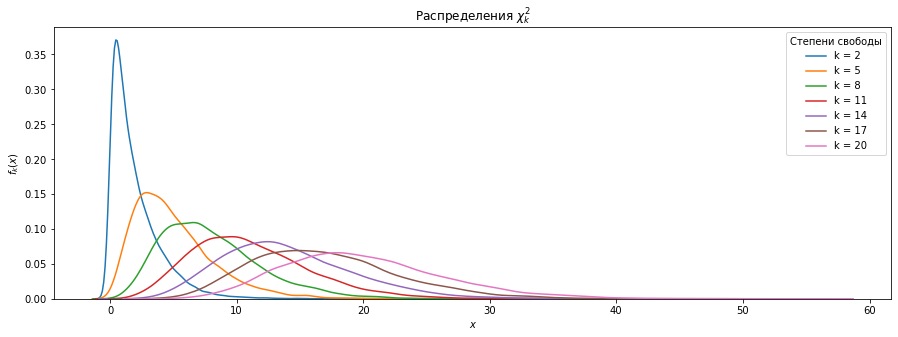

In [2]:
np.random.seed(1234)

size = 10000 # размеры случайных переменных
loc = 0
scale = 1

result = pd.DataFrame([[0] * size], index = ['chi2_1']).T

plt.figure(figsize = (15, 5))

# перебираем значения степеней свободы k
for k in range(2, 22, 3):
    
    # создаем фрейм результатов
    current_result = pd.DataFrame([[0] * size], index = [1]).T
    
    # генерируем нужное количество нормально распределенных переменных, находим сумму их квадратов
    for i in range(1, k + 1): current_result[i] = pd.Series(np.random.normal(loc = loc, scale = scale, size = size))
    
    # находим сумму квадратов
    current_result['chi2'] = (current_result * current_result).sum(axis = 1)
    
    sns.kdeplot(current_result['chi2'], label = 'k = {}'.format(k))

    plt.legend( title = 'Степени свободы'), \
                plt.ylabel('$f_k(x)$'), \
                plt.xlabel('$x$'), \
                plt.title('Распределения $\chi_k^2$')
plt.show()

### 2. χ²-тесты

Существует три χ²-теста.

1. **Тест на гомогенность (test of homogeneity, он же goodness of fit)** — непараметрический, одновыборочный тест, который проверяет соответствие наблюдаемого распределения категориальной случайной величины некоторому эталонному распределению. В Python реализован функцией **scipy.stats.chisquare**.


2. **Тест на независимость (он же test of independence/association)** — непараметрический, одновыборочный тест, который проверяет наличие связи между двумя категориальными переменными. В Python реализован функцией **scipy.stats.chi2_contingency**.


3. **Тест для дисперсии** — параметрический (параметр — дисперсия), одновыборочный тест, который проверяет равенство дисперсии непрерывной случайной величины заданному порогу. В Python для него нет готовой функции.

Первые два теста используют критерий согласия Пирсона (КСП), который имеет распределение χ². Третий тест никак не относится к первым двум за исключением того, что статистика, которую он использует, также имеет распределение χ² (об этом ниже).

**Критерий согласия Пирсона** рассчитывается по формуле: $$\frac{(O - E)^2}{E}$$

Здесь: $O (Observed)$ — наблюдаемое значение; $E (Expected)$ — ожидаемое значение.

Таким образом, **КСП** — это разница между наблюдаемым и ожидаемым значением, возведенная в квадрат (нам важно не направление отличий, а только факт их наличия) и нормированная с помощью деления на ожидаемое значение (чтобы слишком быстро не росла).

Если мы сравниваем набор наблюдаемых значений с набором эталонов, то формула КСП приобретает вид: $$ \sum_{i} \frac{(O_i - E_i)^2}{E_i}$$

В том случае, когда $O$ и $E$ имеют нормальное распределение, **КСП** имеет распределение χ².

Получается, что мы можем провести статистический тест с гипотезами:

* H0: между наблюдаемым распределение и эталонным распределением нет различий;
* H1: между наблюдаемым распределение и эталонным распределением есть различия;

Если различий нет, то **КСП** будет стремиться к нулю. В противном случае она окажется за пределами интервала наиболее вероятных значений:

### 1. Пример с конфетами, χ²-тест на гомогенность (homogeneity, goodness of fit)

Наша гипотеза состоит в том, что пропорции пяти вкусов в каждом пакете одинаковы.

In [3]:
import pandas as pd

df = pd.DataFrame({"Вкус" : ["Яблоко", "Лайм", "Вишня", "Апельсин", "Виноград"],
                   "Observed": [180, 250, 120, 225, 225],
                   "Expected" : [200] * 5}, 
                    dtype = "int")
print(df, '\n')
print(df.dtypes)

       Вкус  Observed  Expected
0    Яблоко       180       200
1      Лайм       250       200
2     Вишня       120       200
3  Апельсин       225       200
4  Виноград       225       200 

Вкус        object
Observed     int32
Expected     int32
dtype: object


In [4]:
def ChiSquare(Observed, Expected):
    
    # рассчитываем статистику
    k = len(Observed)  # число степеней свободы
    
    statistic = (((Observed - Expected)**2 ) / Expected).sum()  # Критерий согласия Пирсона, КСП 
    
    # рассчитываем 
    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                           
    # вероятность получить значение выше или равное статистике
    
    return k - 1, statistic, p_value

ChiSquare(df["Observed"] , df["Expected"])

(4, 52.75, 9.612521889579284e-11)

In [5]:
# результат встроенного теста

from scipy.stats import chisquare
chisquare(df["Observed"], df["Expected"])

Power_divergenceResult(statistic=52.75, pvalue=9.612518035368181e-11)

Сравнив его с уровнем значимости $0.05$, можно сделать вывод о том, что нулевая гипотеза отвергается и конфеты распределены по вкусам неравномерно.

### 2. χ²-тест на независимость

Тест χ²-тест на независимость (test of independence/association) отличается от предыдущего теста постановкой гипотез:
* H0: категориальные переменные A и B независимы;
* H1: категориальные переменные A и B связаны между собой.

Допустим, у нас есть таблица сопряженности (из примера). Таблица сопряженности описывает наблюдаемые (observed) результаты:

<!-- ![image.png](attachment:image.png) -->

In [6]:
import pandas as pd
d = { 'Observed': ['Правая рука длиннее', 'Левая рука длиннее', 'Одинаковые'], 
      'Правая нога длиннее': [11, 2, 12],
      'Левая нога длиннее': [3, 9, 13],
      'Одинаковые': [8, 14, 28]
     }
dfObserved = pd.DataFrame(data = d)
dfObserved

,Observed,Правая нога длиннее,Левая нога длиннее,Одинаковые
0,Правая рука длиннее,11,3,8
1,Левая рука длиннее,2,9,14
2,Одинаковые,12,13,28


In [7]:
df = dfObserved.copy()

df.loc[len(df.index)] = ['Total', 11 + 2 + 12, 3 + 9 + 13, 8 + 14 + 28]
df['Total'] = [11 + 3 + 8, 2 + 9 + 14, 12 + 13 + 28, 25 + 25 + 50]

ALL = df[df['Observed'] == 'Total']['Total'].values[0]

df.loc[len(df.index)] = ['Частота в %', 
                         df[df['Observed'] == 'Total']['Правая нога длиннее'].values[0] / ALL,
                         df[df['Observed'] == 'Total']['Левая нога длиннее'].values[0] / ALL,
                         df[df['Observed'] == 'Total']['Одинаковые'].values[0] / ALL,
                         1]
df['Частота в %'] = [df[df['Observed'] == 'Правая рука длиннее']['Total'].values[0] / ALL,
                     df[df['Observed'] == 'Левая рука длиннее']['Total'].values[0] / ALL,
                     df[df['Observed'] == 'Одинаковые']['Total'].values[0] / ALL ,
                     1, '-']
df

,Observed,Правая нога длиннее,Левая нога длиннее,Одинаковые,Total,Частота в %
0,Правая рука длиннее,11.00,3.00,8.0,22,0.22
1,Левая рука длиннее,2.00,9.00,14.0,25,0.25
2,Одинаковые,12.00,13.00,28.0,53,0.53
3,Total,25.00,25.00,50.0,100,1
4,Частота в %,0.25,0.25,0.5,1,-


Согласно теореме умножения вероятностей, в том случае, когда две случайные величины $A$ и $B$ независимы, вероятность получить совместное событие равна $P(AB) = P(A) \cdot P(B)$. Таким образом, наши ожидаемые $(expected)$ величины можно рассчитать по формуле умножения вероятностей и свести в таблицу:


In [8]:
import pandas as pd
d = { 'Expected': ['Правая рука длиннее', 'Левая рука длиннее', 'Одинаковые'], 
      'Правая нога длиннее': [22 * 0.25, 25 * 0.25, 53 * 0.25],
      'Левая нога длиннее':  [22 * 0.25, 25 * 0.25, 53 * 0.25],
      'Одинаковые':          [22 * 0.50, 25 * 0.50, 53 * 0.50],
     }

dfExpected = pd.DataFrame(data = d)
dfExpected

,Expected,Правая нога длиннее,Левая нога длиннее,Одинаковые
0,Правая рука длиннее,5.50,5.50,11.0
1,Левая рука длиннее,6.25,6.25,12.5
2,Одинаковые,13.25,13.25,26.5


Можем рассчитать статистику по формуле:

$$ \large\sum_{ij}{\frac{(O_{ij}-E_{ij})^2}{E_{ij}}} $$

In [9]:
Observed = dfObserved.drop(['Observed'], axis=1).values
Expected = dfExpected.drop(['Expected'], axis=1).values

((Observed - Expected)**2 / Expected).sum()

11.942092624356777

In [10]:
def Сhi2_Сontingency(contingency_table):
    
    # общее число наблюдений
    total = contingency_table.sum().sum()
    
    # суммы по строкам и столбцам
    col_probs = contingency_table.sum(axis = 0).values
    row_probs = contingency_table.sum(axis = 1).values

    # превращаем их в вероятности
    col_probs = col_probs / total
    row_probs = row_probs / total
    
    # рассчитываем ожидаемые значения
    expected = np.array([col_probs]).T @ np.array([row_probs])              # перемножаем вектор-столбец вероятностей в рядах на вектор-стороку вероятностей в столбцах
    expected = expected.T  
    expected = expected * total
    
    # рассчитываем статистику
    statistic = ((contingency_table.values - expected)**2)/expected
    statistic = statistic.sum()

    # определяем число степеней свободы
    dof = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)
    
    # рассчитываем p-value 
    p_value = 1 - stats.chi2.cdf(statistic, dof)                            # вероятность получить значение выше или равное критерию МП      
    
    return dof, statistic, p_value

contingency_table = pd.DataFrame(dfObserved.drop(['Observed'], axis=1).values)
Сhi2_Сontingency(contingency_table)

(4, 11.942092624356777, 0.01778711460986071)

In [11]:
from scipy.stats import chi2_contingency
chi2_contingency(contingency_table)[0:3]

(11.942092624356777, 0.0177871146098607, 4)

<!-- ### χ²-тест для дисперсии -->